In [1]:
# Import the goods
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tqdm import tqdm
from skopt import BayesSearchCV
from sklearn.metrics import confusion_matrix

data = io.loadmat('mnist-original.mat')

x, y = data['data'].T, data['label'].T
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

C:\Users\dnly\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Setting up a useful dataframe and a mean dataframe
a = pd.DataFrame(data['data'].T)
b = pd.DataFrame(data['label'].T, columns=['label'])
df = pd.concat([a, b], axis=1)
df_mean = df.groupby(['label']).mean()

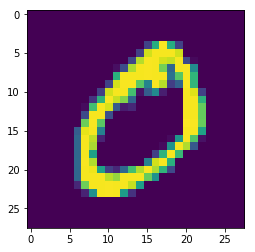

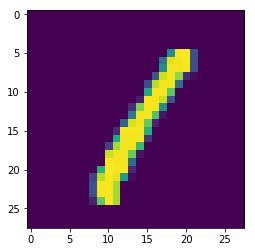

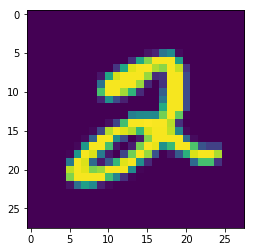

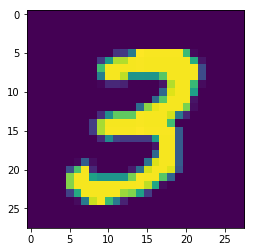

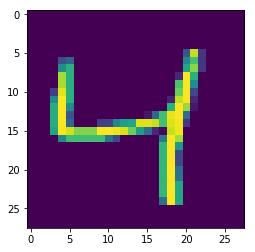

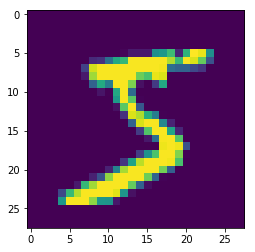

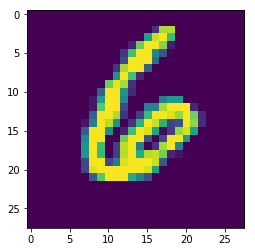

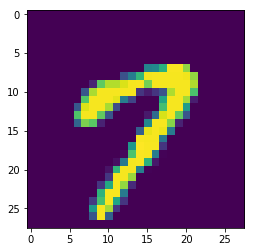

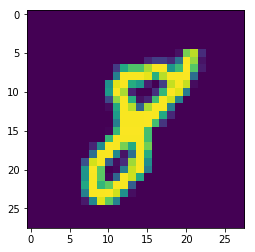

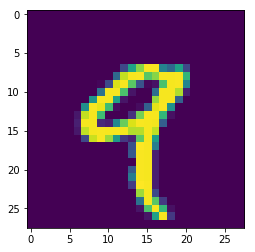

In [3]:
# Visualizing a sample from each class
df_sample = df.drop_duplicates(subset='label')
for i in range(len(df_sample['label'])):
    plt.imshow(np.array(df_sample.iloc[i,:784]).reshape([28,28]))
    plt.show()

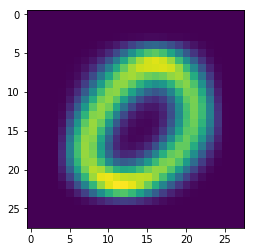

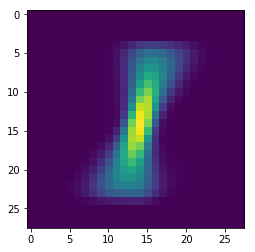

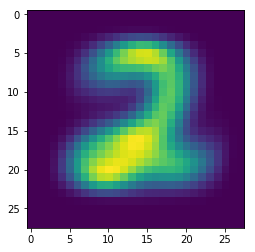

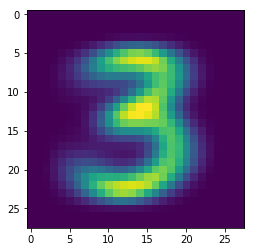

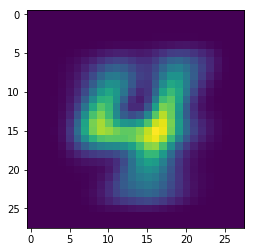

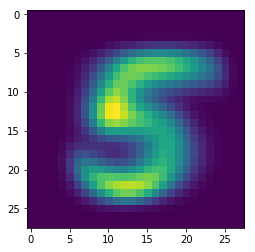

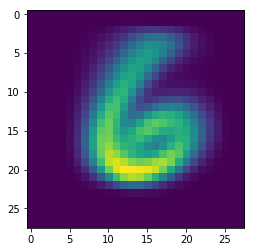

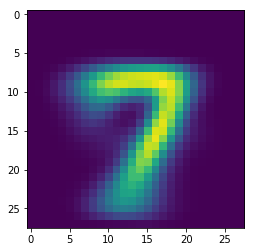

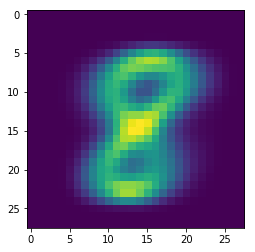

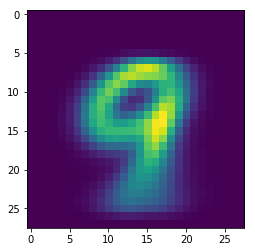

In [4]:
# Visualizing the mean of each class
for i in df_mean.index:
    x = np.array(df_mean[df_mean.index==i]).reshape([28,28])
    plt.imshow(x)
    plt.show()

In [5]:
# Fitting a logistic regression
logit = LogisticRegression(solver='lbfgs')
model = logit.fit(x_train, y_train)

C:\Users\dnly\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
print('The accuracy score of the train set on a logistic regression: ',
      accuracy_score(model.predict(x_train), y_train))
print('The accuracy score of the test set on a logistic regression: ',
      accuracy_score(model.predict(x_test), y_test))

The accuracy score of the train set on a logistic regression:  0.9320857142857143
The accuracy score of the test set on a logistic regression:  0.9112857142857143


Reducing dimensionality using PCA...


In [7]:
# X = df.iloc[:,:len(df.columns)]
# my_pca = PCA(n_components=round(0.5*len(df.columns)))
my_pca = PCA(n_components=0.9)
my_pca.fit(x_train)

# Transform the data
x_train_PCA = my_pca.transform(x_train)
x_test_PCA = my_pca.transform(x_test)

In [8]:
# Fitting a logistic regression
logit_PCA = LogisticRegression(solver='lbfgs')
logit_PCA.fit(x_train_PCA, y_train)

C:\Users\dnly\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
print('The accuracy score of the train set on a logistic regression using PCA to explain 90% of variance: ',
      accuracy_score(logit_PCA.predict(x_train_PCA), y_train))
print('The accuracy score of the test set on a logistic regression using PCA to explain 90% of variance: ',
      accuracy_score(logit_PCA.predict(x_test_PCA), y_test))

The accuracy score of the train set on a logistic regression using PCA to explain 90% of variance:  0.9092285714285714
The accuracy score of the test set on a logistic regression using PCA to explain 90% of variance:  0.9094


Reducing data...

In [10]:
# Logistic regression model of the mean values
mean_model = logit.fit(df_mean.values, df_mean.index)
print('The accuracy score of the train set on a logistic regression using the mean data: ',
      accuracy_score(mean_model.predict(x_train), y_train))
print('The accuracy score of the test set on a logistic regression using the mean data: ',
      accuracy_score(mean_model.predict(x_test), y_test))

The accuracy score of the train set on a logistic regression using the mean data:  0.7683142857142857
The accuracy score of the test set on a logistic regression using the mean data:  0.7706571428571428


In [11]:
# Reducing the number of entries down to 6.25% of the dataset
df_small = df[np.mod(np.arange(df.index.size),2)!=0] # 50%
df_smaller = df_small[np.mod(np.arange(df_small.index.size),2)!=0] # 25%
df_smaller_still  = df_smaller[np.mod(np.arange(df_smaller.index.size),2)!=0] # 12.5%
df_small_enough  = df_smaller_still[np.mod(np.arange(df_smaller_still.index.size),2)!=0] # 6.25%

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(df_small_enough.iloc[:,:-1], df_small_enough['label'], test_size=0.5)

small_model = logit.fit(x_train_s, y_train_s)

In [12]:
print('The accuracy score of the train set on a logistic regression using 6.25% of the data: ',
      accuracy_score(small_model.predict(x_train_s), y_train_s))
print('The accuracy score of the test set on a logistic regression using 6.25% of the data: ',
      accuracy_score(small_model.predict(x_test_s), y_test_s))

The accuracy score of the train set on a logistic regression using 6.25% of the data:  1.0
The accuracy score of the test set on a logistic regression using 6.25% of the data:  0.8171846435100548


Experimenting with KNN between 1 and 15

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:48<00:00,  3.05s/it]


In terms of minimizing the error, the optimal number of neighbors is 3


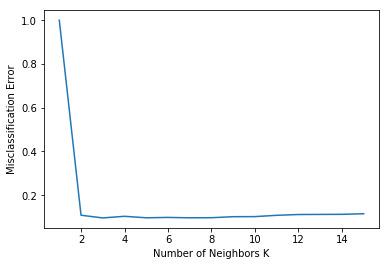

In [13]:
# creating a list for KNN
myList = list(range(1,16))

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for k in tqdm(myList):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, x_train_s, y_train_s, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# making sure the first value for k = 1 is not selected
MSE[0] = 1

# determining best k
optimal_k = myList[MSE.index(min(MSE))]
print(f'In terms of minimizing the error, the optimal number of neighbors is {optimal_k}')

# plot misclassification error vs k
plt.plot(myList, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [14]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(x_test_s, y_test_s)
knn_optimal.score(x_test_s, y_test_s)

0.9602376599634369

KNN for k = 1 and k = n-1

In [15]:
# setting k to 1
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(x_train_s, y_train_s)
print(knn1.score(x_train_s, y_train_s))
print(knn1.score(x_test_s, y_test_s))

1.0
0.906764168190128


In [16]:
# setting k to length of (6.25%) of the data
knnmax = KNeighborsClassifier(n_neighbors=len(x_train_s))
knnmax.fit(x_train_s, y_train_s)
print(knnmax.score(x_train_s, y_train_s))
print(knnmax.score(x_test_s, y_test_s))

0.11156835848193873
0.09734917733089579


Repeating classification using decision trees

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:33<00:00,  2.87s/it]


The optimal number of tree depth is 14


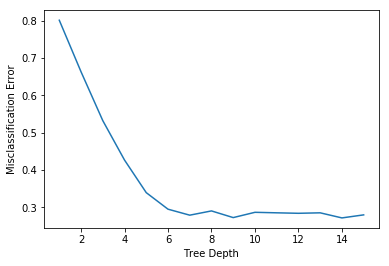

In [17]:
# creating a list for DT
myList = list(range(1,16))

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for d in tqdm(myList):
    dt = tree.DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(dt, x_train_s, y_train_s, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_d = myList[MSE.index(min(MSE))]
print(f'The optimal number of tree depth is {optimal_d}')

# plot misclassification error vs k
plt.plot(myList, MSE)
plt.xlabel('Tree Depth')
plt.ylabel('Misclassification Error')
plt.show()

In [18]:
dt_optimal = tree.DecisionTreeClassifier(max_depth=optimal_d)
dt_optimal.fit(x_train_s, y_train_s)
print(dt_optimal.score(x_train_s, y_train_s))
print(dt_optimal.score(x_test_s, y_test_s))

0.9995427526291724
0.7276051188299817


In [19]:
dt1 = tree.DecisionTreeClassifier(max_depth=1)
dt1.fit(x_train_s, y_train_s)
print(dt1.score(x_train_s, y_train_s))
print(dt1.score(x_test_s, y_test_s))

0.20027434842249658
0.18784277879341865


In [20]:
dtmax = tree.DecisionTreeClassifier()
dtmax.fit(x_train_s, y_train_s)
print(dtmax.score(x_train_s, y_train_s))
print(dtmax.score(x_test_s, y_test_s))

1.0
0.7230347349177331


Using a SVC with Bayesian gridsearch

In [21]:
# optional cell to load prebuilt model
from sklearn.externals import joblib
# joblib.dump(opt, 'optimal_svc_model.pkl') 
opt = joblib.load('optimal_svc_model.pkl') 

In [ ]:
opt = BayesSearchCV(
    SVC(probability=True),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32
)

opt.fit(x_train_s, y_train_s)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(x_test_s, y_test_s))

Using a confusion matrix to identify confounding classes

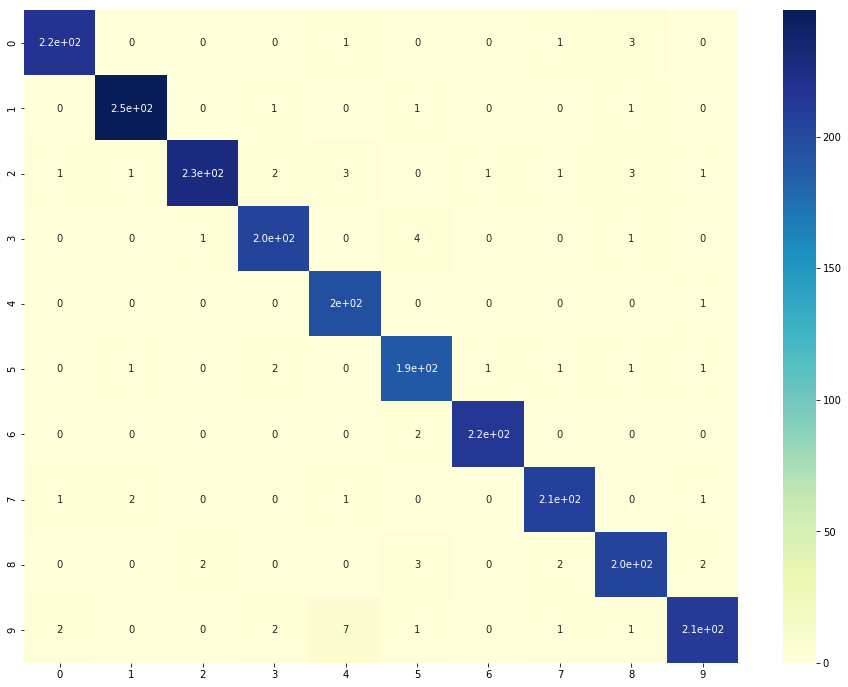

In [22]:
cm = confusion_matrix(y_test_s, opt.predict(x_test_s))
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.show()

Let's refit a model just to classify 4s and 9s

In [23]:
df49 = df[(df['label']==4)|(df['label']==9)]

In [30]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

x_train_lm, x_test_lm, y_train_lm, y_test_lm = train_test_split(
    df49.drop(columns='label').values, 
    df49['label'].values, 
    test_size=0.5
)

sc = StandardScaler()
x_train_lm = sc.fit_transform(x_train_lm)

logit = LinearSVC(C=0.01)
logit.fit(x_train_lm, y_train_lm)

C:\Users\dnly\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dnly\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

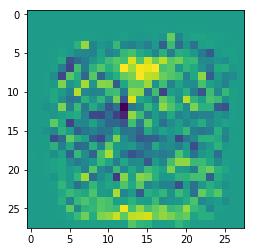

In [31]:
# sns.heatmap(logit.coef_)
# print(logit.coef_.mean())
# print(logit.coef_.std())
plt.imshow(logit.coef_.reshape([28,28]))
plt.show()

In [32]:
logit.score(x_test_lm, y_test_lm)

0.9563198374691627

Using a simple convoluted neural network to predict classes

In [1]:
from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical
from sklearn.externals import joblib

from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from sklearn import datasets
import numpy as np
from sklearn.preprocessing import label_binarize

Using TensorFlow backend.


In [2]:
#Making Keras picklable, from rosey

def make_keras_picklable():
    import tempfile
    import keras.models

    def __getstate__(self):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as temp:
            keras.models.save_model(self, temp.name, overwrite=True)
            model_str = temp.read()
        return {'model_str': model_str}

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as temp:
            temp.write(state['model_str'])
            temp.flush()
            model = keras.models.load_model(temp.name)
        self.__dict__ = model.__dict__

    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

In [3]:
#loading and preprocessing the data

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
# 
# covnet.save('covnet_model.hdf5')
covnet = models.load_model('covnet_model.hdf5')

In [ ]:
#convoluted neural network
covnet = models.Sequential()
#use convolution to create new feature maps based on a 3x3 window
covnet.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
#use maxpooling to reduce the amount of feature-map coefficients
covnet.add(layers.MaxPooling2D((2, 2)))
covnet.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
covnet.add(layers.MaxPooling2D((2, 2)))
covnet.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
covnet.add(layers.Flatten())
# covnet.add(layers.Dropout(0.1))
covnet.add(layers.Dense(64, activation='relu'))
covnet.add(layers.Dense(10, activation='softmax'))

In [ ]:
covnet.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [5]:
covnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3136)              0         
__________

In [ ]:
covnet.fit(train_images, train_labels, epochs=50, batch_size=64)

In [7]:
test_loss, test_acc = covnet.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 5s 460us/step
test_acc: 0.9936
